# 주제 : 아마존 푸드 리뷰 데이터 감성 분석 모델 및 요약문 추출 모델 구현
데이터 정보 : Kaggle의 Amazon food reviews data

데이터 및 주제 선정 이유
1. 커머스를 운영하는 기업의 입장에서 고객의 pain point가 무엇인지 파악하기 위해서 고객 리뷰 데이터에 주목함.
2. 엄청나게 쌓이는 리뷰 데이터를 모두 확인하고 분류하는데  많은 시간과 비용이듬. 이를 자동화하여 비용을 줄이기 위함.
3. 가장 많이 쌓이고 빈번하게 발생하는 클레임건들을 바탕으로 업무의 우선순위(개발팀의 개발 우선 순위)를 정하는데 이용할 수 있음.
4. 종합적으로, 서비스를 이용하는 고객님들의 입장에서 느껴지는 자사 플랫폼의 약점을 보완하는데 사용하고자 함.(ex. 제품, 배송서비스, CS 등)

데이터 분석 프로세스
1. EDA 및 데이터 전처리
2. 첫번째 모델 : 고객 평점을 바탕으로 5점을 받은 리뷰 텍스트는 긍정, 4점 이하를 받은 리뷰 텍스트는 부정으로 이진 분류 모델 구현
이유 : 고객님들이 평점 5점을 주는 경우, 모든 제품과 서비스에 만족을 했거나 혹은 의미없이 주는 경우가 있다고 생각하였음. 반면에, 4점 이하의 경우, 불만족하는 요소가 적어도 한개 이상이 있을 것이라 생각하여 부정으로 처리한 것임.
3. 두번째 모델 : 리뷰 텍스트와 요약문을 라벨링한 데이터들을 바탕으로 요약문 추출 모델 구현
4. 첫번째 모델에서 부정으로 분류된 리뷰 텍스트들을 두번째 모델의 데이터로 넣어 부정적인 요소를 요약할 수 있는 요약문 모델로 활용

핵심키워드 : NLP, 랜덤포레스트, XGboost, LSTM, Attention 등


# 두번째 모델 : 리뷰 텍스트 요약문 추출 모델 구현

### 1. 데이터 및 라이브러리 호출

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (6,406 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 160837 files and d

In [ ]:
pip install beautifulsoup4

In [ ]:
!python -m spacy download en_core_web_md
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 96.4 MB 1.1 MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-py3-none-any.whl size=98051301 sha256=b7aad06dccaf3c61e577d763e3d9f7cecc533d837ff2868f05552f2d512b2048
  Stored in directory: /tmp/pip-ephem-wheel-cache-75hfx_ll/wheels/69/c5/b8/4f1c029d89238734311b3269762ab2ee325a42da2ce8edb997
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')
     |████████████████████████████████| 12.0 MB 5.0 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [ ]:
# API Token 다운받기
# 다운받은 API Token 업로드 하기
!pip install kaggle
from google.colab import files
files.upload()
# json 파일 옮겨주기
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json
# json 파일 제대로 업로드 됐는지 확인
# 본인이 참가한 모든 대회 보기 
!kaggle competitions list
# 데이터셋 다운로드 받기 - 링크는 그 대회 'Data'에 있음
!kaggle datasets download -d snap/amazon-fine-food-reviews
# 다운로드 된 것들 다 보기 
!ls
# 필요하면 압축 풀기 


Saving kaggle.json to kaggle.json
ref                                                  deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                         2030-07-01 23:59:00  Getting Started     Prizes        234           False  
gan-getting-started                                  2030-07-01 23:59:00  Getting Started     Prizes        401           False  
tpu-getting-started                                  2030-06-03 23:59:00  Getting Started  Knowledge       1043           False  
digit-recognizer                                     2030-01-01 00:00:00  Getting Started  Knowledge       6782           False  
titanic                                              2030-01-01 00:00:00  Getting Started  Knowledge      57953           False  
house-prices-advanced-regression-techniques          203

In [ ]:
!unzip amazon-fine-food-reviews.zip

Archive:  amazon-fine-food-reviews.zip
  inflating: Reviews.csv             
  inflating: database.sqlite         
  inflating: hashes.txt              


In [ ]:
pip install transformers

     |████████████████████████████████| 2.6 MB 5.2 MB/s 
     |████████████████████████████████| 636 kB 33.1 MB/s 
     |████████████████████████████████| 895 kB 41.1 MB/s 
     |████████████████████████████████| 3.3 MB 65.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from urllib import request
request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")

('attention.py', <http.client.HTTPMessage at 0x7f6549fcc650>)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import os

import spacy
import re
import scipy.stats as stats
import warnings
warnings.filterwarnings(action = 'ignore')
nlp = spacy.load('en_core_web_sm')

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, KFold, cross_val_score
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import f1_score, recall_score, precision_score
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from transformers import BertTokenizer, BertModel
from attention import AttentionLayer

import urllib.request
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import nltk
nltk.download('all')  

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

True

### 2. EDA 및 데이터 전처리

In [ ]:
df = pd.read_csv('Reviews.csv')
df = df[['Text', 'Summary']]
df

,Text,Summary
0,I have bought several of the Vitality canned d...,Good Quality Dog Food
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised
2,This is a confection that has been around a fe...,"""Delight"" says it all"
3,If you are looking for the secret ingredient i...,Cough Medicine
4,Great taffy at a great price. There was a wid...,Great taffy
...,...,...
568449,Great for sesame chicken..this is a good if no...,Will not do without
568450,I'm disappointed with the flavor. The chocolat...,disappointed
568451,"These stars are small, so you can give 10-15 o...",Perfect for our maltipoo
568452,These are the BEST treats for training and rew...,Favorite Training and reward treat


In [ ]:
df.isnull().sum()

Text        0
Summary    27
dtype: int64

In [ ]:
df[df.duplicated()].sort_values('Text')

,Text,Summary
418609,"""BUFFY"" LOOKS FORWARD TO HER ""TOY"" EVERY AFTER...",GREAT DOG TREAT
561246,"""Blends smooth and creamy for a sweet tasting ...",Buy this if you have NO taste buds!
245224,"""Both"" of Gloria Jean's ""Hazelnut"" and ""Vanill...",Packaging quality problem
233264,"""Both"" of Gloria Jean's ""Hazelnut"" and ""Vanill...",Packaging quality problem
473106,"""Both"" of Gloria Jean's ""Hazelnut"" and ""Vanill...",Packaging quality problem
...,...,...
268751,zico probably has the best taste of the coconu...,great tasting
211949,zico probably has the best taste of the coconu...,great tasting
358777,zico probably has the best taste of the coconu...,great tasting
167012,"~ I ordered Farie's Finest Coconut powder, Map...","EXCELLENT Quality & Taste; Very, Very Versatil..."


In [ ]:
df = df.drop_duplicates()
df

,Text,Summary
0,I have bought several of the Vitality canned d...,Good Quality Dog Food
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised
2,This is a confection that has been around a fe...,"""Delight"" says it all"
3,If you are looking for the secret ingredient i...,Cough Medicine
4,Great taffy at a great price. There was a wid...,Great taffy
...,...,...
568449,Great for sesame chicken..this is a good if no...,Will not do without
568450,I'm disappointed with the flavor. The chocolat...,disappointed
568451,"These stars are small, so you can give 10-15 o...",Perfect for our maltipoo
568452,These are the BEST treats for training and rew...,Favorite Training and reward treat


In [ ]:
df = df.dropna(axis = 0)

In [ ]:
stop_words = set(stopwords.words('english'))
print('불용어 개수 :', len(stop_words))
print(stop_words)

불용어 개수 : 179
{'shouldn', 'my', 'until', 'ourselves', 'hasn', 'off', 'me', 'should', 'now', 'any', 'or', 'ain', 'same', 'after', 'the', 'not', 't', 'theirs', 'so', "hadn't", 'him', 'can', 'don', 'mightn', 'in', 'we', 'nor', 'have', 'has', "needn't", "didn't", "aren't", 'about', 'itself', 'into', 'few', 'haven', 'once', 'down', 'under', 'they', "weren't", "mightn't", 'them', 'had', 'here', 'y', 'their', 'this', 'am', 'before', "don't", 'all', 'was', 'some', 'couldn', 'each', 'are', 'o', 'when', 'been', 'own', 'do', 'where', "haven't", 'what', "it's", "won't", "that'll", 'how', 'most', "doesn't", 'a', 'our', 'because', "wasn't", 'ma', 'that', 'and', 'didn', 'were', 'himself', 'as', 'between', 'during', "shouldn't", 'for', "should've", 're', 'ours', 'she', 'at', 'themselves', 'being', "you'll", 'up', 'then', 'doesn', 'whom', "couldn't", "mustn't", 'it', "hasn't", 'no', 'mustn', "you're", 'shan', 'too', 'over', 'will', 'but', 'he', 'to', 'you', 'than', "you've", 'those', 'an', 'only', 've',

In [ ]:
def text_size(data):
    data_review = [review for review in data if type(review) is str]
    wordcloud = WordCloud('NanumGothic.ttf').generate(' '.join(data_review))
    plt.figure(figsize = (20, 10))
    plt.title('Word frequency', fontsize = 30)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    
    return plt.show()

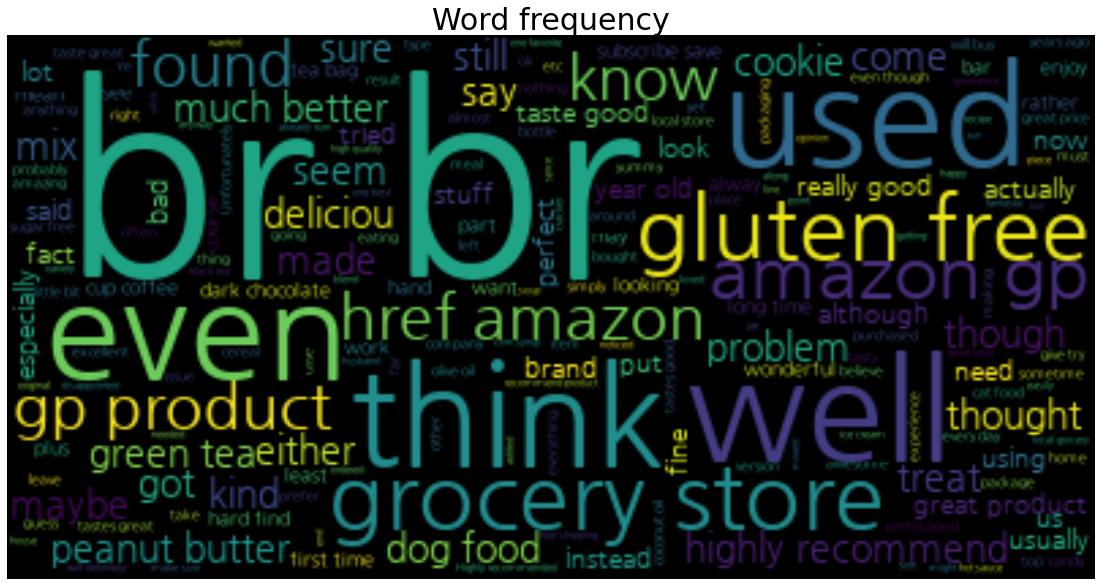

In [ ]:
text_size(df['Text'])

이것 또한 앞선 감성 분석 모델 전처리와 동일하게 HTML이 눈에 띄기 때문에 제거해준다.

In [ ]:
def preprocess_sentence(sentence, remove_stopwords = True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열  제거 Ex) my husband (and myself) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
#     sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stop_words if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [ ]:
clean_text = []
for s in df['Text']:
    clean_text.append(preprocess_sentence(s))
clean_text[:5]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

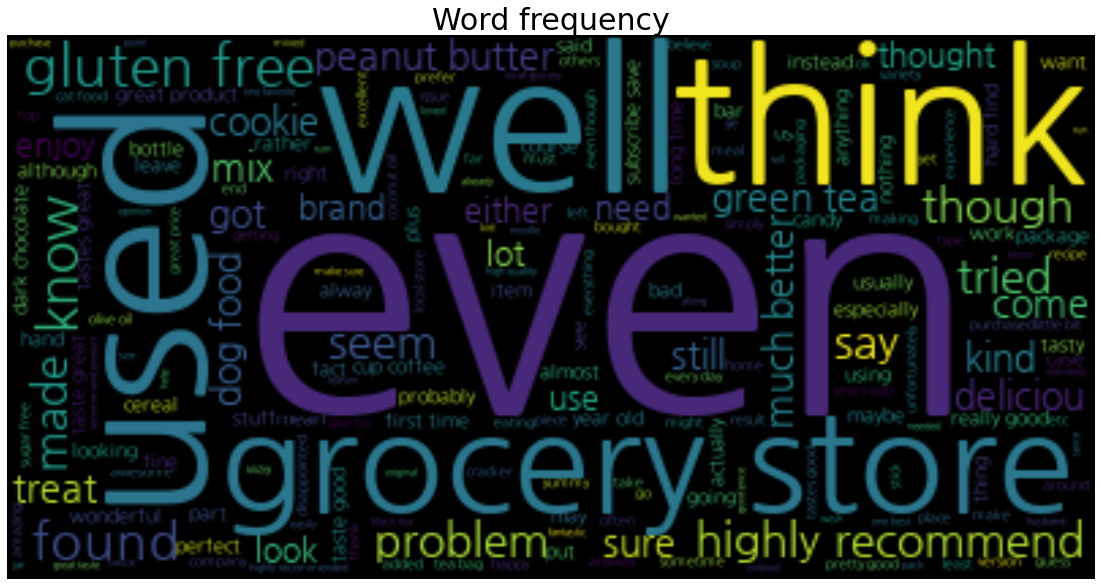

In [ ]:
text_size(clean_text)

전처리가 어느 정도 잘된 것으로 보여진다.

In [ ]:
clean_summary = []
for s in df['Summary']:
    clean_summary.append(preprocess_sentence(s, 0))
clean_summary[:5]

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy']

In [ ]:
df['Text'] = clean_text
df['Summary'] = clean_summary

df.replace('', np.nan, inplace=True)
print(df.isnull().sum())

Text         3
Summary    352
dtype: int64


In [ ]:
df.dropna(axis = 0, inplace = True)
print('전체 샘플수 :',(len(df)))
print('샘플 유형', df.shape)

전체 샘플수 : 394613
샘플 유형 (394613, 2)


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 1918
텍스트의 평균 길이 : 37.94125383603683
요약의 최소 길이 : 1
요약의 최대 길이 : 27
요약의 평균 길이 : 3.931041298690109


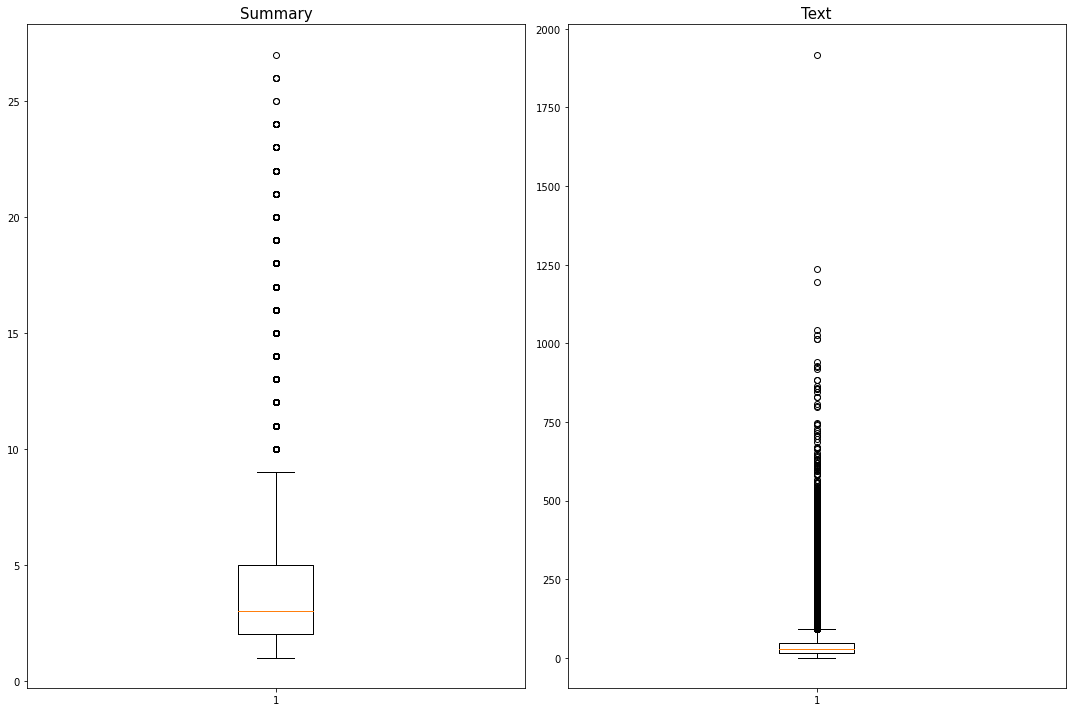

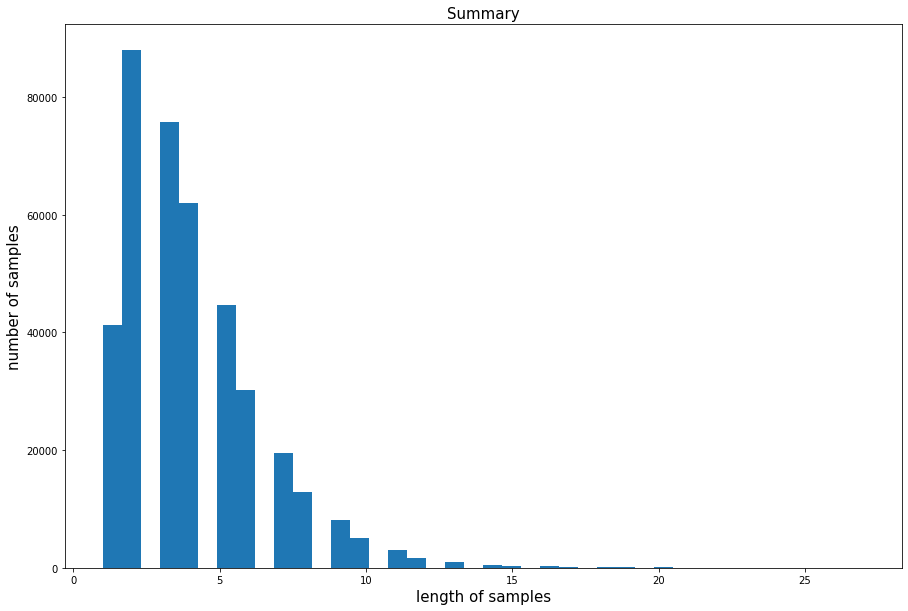

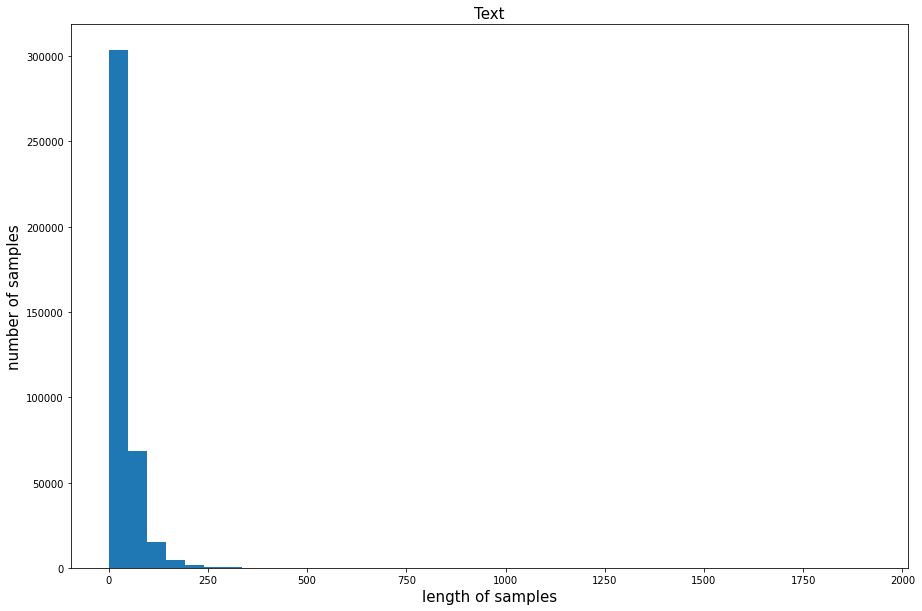

In [ ]:
text_len = [len(s.split()) for s in df['Text']]
summary_len = [len(s.split()) for s in df['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.figure(figsize = (15, 10))
plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary', fontsize = 15)
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text', fontsize = 15)
plt.tight_layout()
plt.show()

plt.figure(figsize = (15, 10))
plt.title('Summary', fontsize = 15)
plt.hist(summary_len, bins=40)
plt.xlabel('length of samples', fontsize = 15)
plt.ylabel('number of samples', fontsize = 15)
plt.show()

plt.figure(figsize = (15, 10))
plt.title('Text', fontsize = 15)
plt.hist(text_len, bins=40)
plt.xlabel('length of samples', fontsize = 15)
plt.ylabel('number of samples', fontsize = 15)
plt.show()

In [ ]:
length = pd.DataFrame(text_len, summary_len).reset_index().rename(columns = {'index':'text_len', 0:'summary_len'})
length.describe()

,text_len,summary_len
count,394613.000000,394613.000000
mean,3.931041,37.941254
std,2.414285,36.473431
min,1.000000,1.000000
25%,2.000000,16.000000
50%,3.000000,27.000000
75%,5.000000,46.000000
max,27.000000,1918.000000


In [ ]:
print('3사분위에 1.5 곱한 요약문 길이:', 5*1.5) 
print('3사분위에 1.5 곱한 텍스트 길이:', 45*1.5)
## 최대 길이 설정해줌.

3사분위에 1.5 곱한 요약문 길이: 7.5
3사분위에 1.5 곱한 텍스트 길이: 67.5


In [ ]:
text_max_len = 67
summary_max_len = 7

In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [ ]:
below_threshold_len(text_max_len, df['Text'])
below_threshold_len(summary_max_len, df['Summary'])

전체 샘플 중 길이가 67 이하인 샘플의 비율: 0.8742565500883144
전체 샘플 중 길이가 7 이하인 샘플의 비율: 0.9159353594534392


In [ ]:
df = df[df['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
df = df[df['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :',(len(df)))

전체 샘플수 : 321917


In [ ]:
df['decoder_input'] = df['Summary'].apply(lambda x : 'sostoken '+ x)
df['decoder_target'] = df['Summary'].apply(lambda x : x + ' eostoken')
df.head(), df.shape

(                                                Text  ...                  decoder_target
 0  bought several vitality canned dog food produc...  ...  good quality dog food eostoken
 1  product arrived labeled jumbo salted peanuts p...  ...      not as advertised eostoken
 2  confection around centuries light pillowy citr...  ...    delight says it all eostoken
 3  looking secret ingredient robitussin believe f...  ...         cough medicine eostoken
 4  great taffy great price wide assortment yummy ...  ...            great taffy eostoken
 
 [5 rows x 4 columns], (321917, 4))

In [ ]:
encoder_input = np.array(df['Text'])
decoder_input = np.array(df['decoder_input'])
decoder_target = np.array(df['decoder_target'])

In [ ]:
indices = np.arange(encoder_input.shape[0]) ## 랜덤으로 섞기.
np.random.shuffle(indices)
print(indices)

[312319 156669 118390 ... 295810  95675 173098]


In [ ]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [ ]:
indices

array([312319, 156669, 118390, ..., 295810,  95675, 173098])

In [ ]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 64383


In [ ]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [ ]:
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 257534
훈련 레이블의 개수 : 257534
테스트 데이터의 개수 : 64383
테스트 레이블의 개수 : 64383


In [ ]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

In [ ]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 78223
등장 빈도가 6번 이하인 희귀 단어의 수: 59112
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 19111
단어 집합에서 희귀 단어의 비율: 75.56856678981885
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.4549944318016752


In [ ]:
src_vocab = 20000 #7회 이상 빈도가 높은 단어들을 대상으로 정한 기준
src_tokenizer = Tokenizer(num_words = src_vocab) 
src_tokenizer.fit_on_texts(encoder_input_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

In [ ]:
print(encoder_input_train[:3])

[[40, 4, 672, 259, 13, 3999, 255, 32, 2398, 61, 1221, 404, 1113, 87, 458, 753, 404, 753, 53, 1145, 2, 2, 10691, 243, 1902, 199, 1331, 77, 374, 2, 117, 282, 131, 584, 3254, 5110, 369, 1651, 3541, 439, 702], [13, 1, 343, 91, 355, 923, 263, 3407, 108, 2248, 7, 2860, 4, 128, 1165, 2563, 4, 4, 4, 592, 28, 15259, 3195, 231, 263, 730, 857, 22, 149, 1373, 857, 2581, 3097, 17, 315, 1321, 828, 422, 2, 691, 225, 8, 9, 111, 12, 287, 263], [2, 5, 2, 3317, 30, 2, 3317, 17, 87, 272, 2, 325, 2171, 1194, 1131, 36, 648, 1565, 325]]


In [ ]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [ ]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 24326
등장 빈도가 5번 이하인 희귀 단어의 수: 18269
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 6057
단어 집합에서 희귀 단어의 비율: 75.10071528405821
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.7367306148248116


In [ ]:
tar_vocab = 6000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

In [ ]:
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

In [ ]:
print(decoder_input_train[:5])
print(decoder_target_train[:5])

[[1, 38, 4], [1, 6, 12, 234, 274], [1, 1357, 351, 371, 36], [1, 90, 732, 455, 94, 383], [1, 665, 275]]
[[38, 4, 2], [6, 12, 234, 274, 2], [1357, 351, 371, 36, 2], [90, 732, 455, 94, 383, 2], [665, 275, 2]]


In [ ]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

삭제할 훈련 데이터의 개수 : 3035
삭제할 테스트 데이터의 개수 : 894


In [ ]:
encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 254499
훈련 레이블의 개수 : 254499
테스트 데이터의 개수 : 63489
테스트 레이블의 개수 : 63489


In [ ]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding='post')

### 3. LSTM with Attention 모델 구현

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

strategy = tf.distribute.TPUStrategy(resolver)

INFO:tensorflow:Initializing the TPU system: grpc://10.80.122.146:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.80.122.146:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(20000, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# 디코더
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
with strategy.scope():
    model_attention = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
    model_attention.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 67)]         0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 67, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 67, 256), (N 394240      embedding_12[0][0]               
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [ ]:
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model_attention = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model_attention.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])
model_attention.summary()

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f637147fd40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1267, in delete_iterator
    _ops.raise_from_not_ok_status(e, name)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/ops.py", line 6897, in raise_from_not_ok_status
    six.raise_from(core._status_to_exception(e.code, message), None)
  File "<string>", line 3, in raise_from
tensorflow.python.framework.errors_impl.NotFoundError: Container AnonymousIterator does not exist. [Op:DeleteIterator]


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 67)]         0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 67, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 67, 256), (N 394240      embedding_12[0][0]               
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [ ]:
model_name = "lstm_attention"
checkpoint_path = os.path.join(model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 10, restore_best_weights = True)


history = model_attention.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 512, callbacks=[es, cp_callback], epochs = 30)

lstm_attention -- Folder create complete 

Epoch 1/30
498/498 [==============================] - 605s 1s/step - loss: 3.1664 - accuracy: 0.5467 - val_loss: 2.8692 - val_accuracy: 0.5732

Epoch 00001: val_loss improved from inf to 2.86924, saving model to lstm_attention/weights.h5
Epoch 2/30
498/498 [==============================] - 591s 1s/step - loss: 2.7131 - accuracy: 0.5842 - val_loss: 2.5521 - val_accuracy: 0.5947

Epoch 00002: val_loss improved from 2.86924 to 2.55212, saving model to lstm_attention/weights.h5
Epoch 3/30
498/498 [==============================] - 592s 1s/step - loss: 2.4610 - accuracy: 0.5999 - val_loss: 2.3875 - val_accuracy: 0.6057

Epoch 00003: val_loss improved from 2.55212 to 2.38752, saving model to lstm_attention/weights.h5
Epoch 4/30
498/498 [==============================] - 592s 1s/step - loss: 2.3069 - accuracy: 0.6101 - val_loss: 2.2751 - val_accuracy: 0.6140

Epoch 00004: val_loss improved from 2.38752 to 2.27511, saving model to lstm_attention/weig

### 4. LSTM with Attention 모델 성능 평가

In [ ]:
attention_score_test = model_attention.evaluate([encoder_input_test, decoder_input_test], decoder_target_test)
attention_score_test[0], attention_score_test[1]

1985/1985 [==============================] - 132s 66ms/step - loss: 2.0613 - accuracy: 0.6344


(2.0612881183624268, 0.6344451308250427)

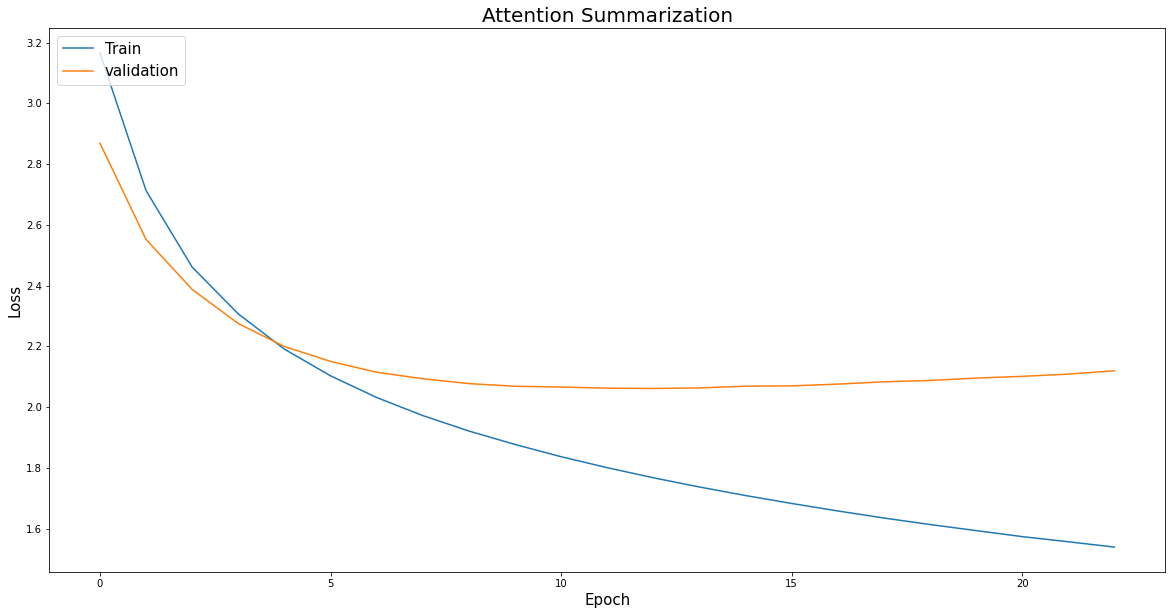

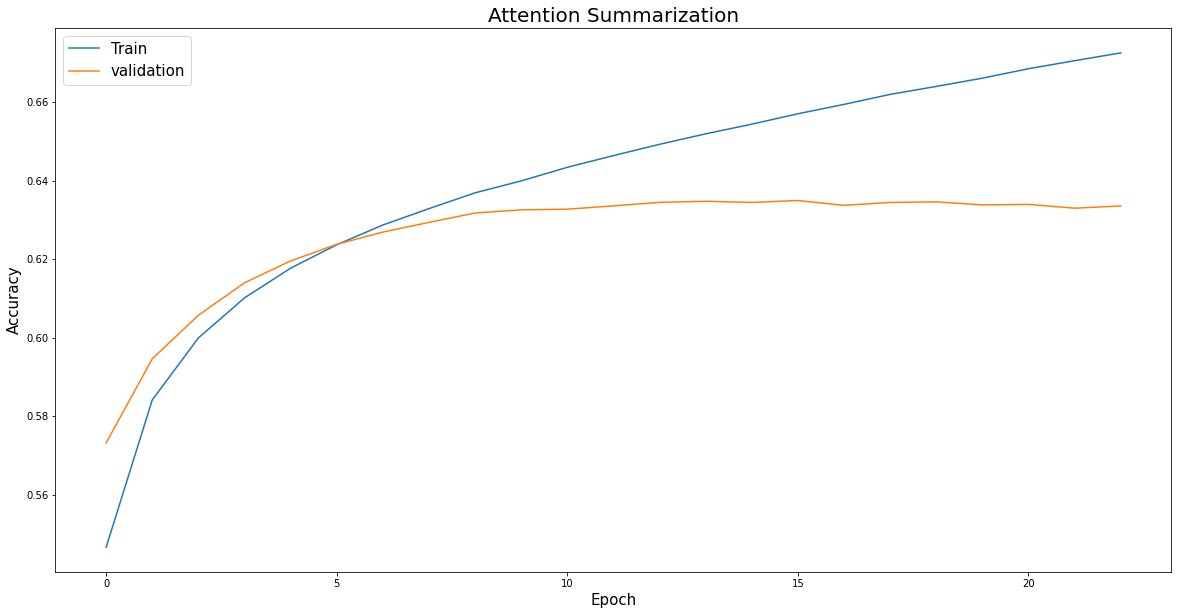

In [ ]:
# Plot training & validation loss values
plt.figure(figsize = (20, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Attention Summarization', fontsize = 20)
plt.ylabel('Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.legend(['Train', 'validation'], loc='upper left', fontsize = 15)
plt.show();

# Plot training & validation accuracy values
plt.figure(figsize = (20, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Attention Summarization', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.legend(['Train', 'validation'], loc='upper left', fontsize = 15)
plt.show();

세팅을 변경하면서 진행했을 때, 테스트 결과, 0.63의 성능이 나왔다. 결론적으로 일반화하기는 어려운 모델로 판단하였다.. 
동일한 프로젝트였음에도 불구하고 이전보다 정확도가 많이 떨어진 이유는 중복값 제거를 한 점으로 추론할 수 있었다.
중복데이터가 학습 데이터와 테스트 데이터로 분할이 되었다면, 데이터 누수에 의해서 누출된 데이터는 정확하게 예측했기 때문에 성능이 중복 데이터 전처리를 해주기 이전보다 높게 나왔다고 볼 수 있다.
데이터 분석, 모델링을 진행할 때 데이터 누수를 주의해야 하는 이유를 직접 깨달을 수 있었다.

### 5. 실제 요약문 추출 테스트 진행

In [ ]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [ ]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [ ]:
## 0~50번째 텍스트의 요약문을 추출해본다.
for i in range(0, 50):
    print("원문 : ",seq2text(encoder_input_test[i]))
    print("실제 요약문 :",seq2summary(decoder_input_test[i]))
    print("예측 요약문 :",decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 :  outstanding chai tea make easy chai latte take one tea bag fill cup full water microwave couple minutes let sit add teaspoon sugar top milk heat 
실제 요약문 : great chai tea 
예측 요약문 :  chai tea


원문 :  daughter enamel defect teeth dentist recommended xylitol gum flavor last long suppose help decay etc chew brush instead sugary gum good option price great amazon vs local health food store 
실제 요약문 : dentist recommended 
예측 요약문 :  great gum


원문 :  cats know picky eaters avoderm salmon satisfies even picky eater vet tells cats healthy bright eyes shiny coats 
실제 요약문 : avoderm natural salmon cat formula 
예측 요약문 :  cats love it


원문 :  item listed cups picture description says pod knows company calls items use keurig deceiving non returnable disappointed order 
실제 요약문 : careful 
예측 요약문 :  misleading description


원문 :  thankful oatmeal severe gluten corn allergies tastes great worry cross contamination allergies highly recommend 
실제 요약문 : love it 
예측 요약문 :  great gluten free cereal


원문 :

전처리에서 중복 데이터를 제거해준 후, 초기 프로젝트때 보다 성능이 떨어졌다. 역시, EDA를 통한 전처리의 중요성을 느낄 수 있었다. 뿐만 아니라, 목표하던 부정적인 문구를 추출하기 위해선 라벨링의 중요성을 느낄 수 있었다. 즉, 어떠한 문장이 들어오더라도 그 안에서 있는 부정적인 문구에 집중할 수 있도록 부정적인 라벨이 추출되는 방식으로 학습 진행이 필요할 것으로 판단된다.

LSTM with Attention 모델이 생각보다 성능이 좋지 않았기 때문에, Transformer를 활용하여 요약문 모델을 구현해보기로 했다.

## Transformer 모델 구현

#### 패딩 및 포워드 마스킹

In [ ]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # 패딩을 넣기 위해 어텐션 로짓(logit)에 추가적인 차원을 넣습니다.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [ ]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)

    return mask

In [ ]:
def create_masks(inp, tar):
    # 패딩 마스크 인코더
    enc_padding_mask = create_padding_mask(inp)

    # 디코더의 두 번재 어텐션 블록에 사용됩니다.
    # 이 패딩 마스크는 인코더 출력값을 마스킹하기 위해 사용합니다.
    dec_padding_mask = create_padding_mask(inp)

    # 디코더의 첫 번째 어텐션 블록에 사용됩니다.
    # 디코더에서 받은 입력의 향후의 토큰을 패딩하고 마스크하기 위해 사용됩니다.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

#### 포진셔널 인코딩

In [ ]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2*i) / np.float32(d_model))

    return pos * angle_rates


def posional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype = tf.float32)

#### 스케일 내적 어텐션

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b = True)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis = -1)
    output = tf.matmul(attention_weights, v)

    return output, attention_weights

#### 멀티헤드 어텐션

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = kargs['num_heads']
        self.d_model = kargs['d_model']

        assert self.d_model % self.num_heads == 0

        self.depth = self.d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(kargs['d_model'])
        self.wk = tf.keras.layers.Dense(kargs['d_model'])
        self.wv = tf.keras.layers.Dense(kargs['d_model'])

        self.dense = tf.keras.layers.Dense(kargs['d_model'])

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm = [0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q) # (batch_size, seq_len, d_model)
        k = self.wk(k) # (batch_size, seq_len, d_model)
        v = self.wv(v) # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm = [0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        output = self.dense(concat_attention)

        return output, attention_weights

#### 포인트 와이즈 피드포워드 네트워크

In [ ]:
def point_wise_feed_forward_network(**kargs):
    return tf.keras.Sequential([
                                tf.keras.layers.Dense(kargs['dff'], activation = 'relu'),
                                tf.keras.layers.Dense(kargs['d_model'])
    ])

#### 인코더 레이어

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(**kargs)
        self.ffn = point_wise_feed_forward_network(**kargs)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)

        self.dropout1 = tf.keras.layers.Dropout(kargs['rate'])
        self.dropout2 = tf.keras.layers.Dropout(kargs['rate'])

    def call(self, x, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

#### 디코더 레이어

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(**kargs)
        self.mha2 = MultiHeadAttention(**kargs)

        self.ffn = point_wise_feed_forward_network(**kargs)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)

        self.dropout1 = tf.keras.layers.Dropout(kargs['rate'])
        self.dropout2 = tf.keras.layers.Dropout(kargs['rate'])
        self.dropout3 = tf.keras.layers.Dropout(kargs['rate'])

    def call(self, x, enc_output, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2

#### 인코더

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(Encoder, self).__init__()

        self.d_model = kargs['d_model']
        self.num_layers = kargs['num_layers']

        self.embedding = tf.keras.layers.Embedding(kargs['input_vocab_size'], self.d_model)
        self.pos_encoding = posional_encoding(kargs['maximum_position_encoding'], self.d_model)

        self.enc_layers = [EncoderLayer(**kargs) for _ in range(self.num_layers)]
        self.dropout = tf.keras.layers.Dropout(kargs['rate'])

    def call(self, x, mask):
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, mask)

        return x

#### 디코더

In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(Decoder, self).__init__()

        self.d_model = kargs['d_model']
        self.num_layers = kargs['num_layers']

        self.embedding = tf.keras.layers.Embedding(kargs['target_vocab_size'], self.d_model)
        self.pos_encoding = posional_encoding(kargs['maximum_position_encoding'], self.d_model)
        self.dec_layers = [DecoderLayer(**kargs) for _ in range(self.num_layers)]
        self.dropout = tf.keras.layers.Dropout(kargs['rate'])

    def call(self, x, enc_output, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        return x, attention_weights

#### 트랜스포머 모델 구축

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self, **kargs):
        super(Transformer, self).__init__()
        self.end_token_idx = kargs['end_token_idx']

        self.encoder = Encoder(**kargs)
        self.decoder = Decoder(**kargs)

        self.final_layer = tf.keras.layers.Dense(kargs['target_vocab_size'])

    def call(self, x):
        inp, tar = x

        enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(inp, tar)
        enc_output = self.encoder(inp, enc_padding_mask)
        dec_output, _ = self.decoder(tar, enc_output, look_ahead_mask, dec_padding_mask)
        final_output = self.final_layer(dec_output)

        return final_output

    def inference(self, x):
        inp = x
        tar = tf.expand_dims([STD_INDEX], 0)

        enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(inp, tar)
        enc_output = self.encoder(inp, enc_padding_mask)

        predict_tokens = list()
        for t in range(0, MAX_SEQUENCE):
            dec_output, _ = self.decoder(tar, enc_output, look_ahead_mask, dec_padding_mask)
            final_output = self.final_layer(dec_output)
            outputs = tf.argmax(final_output, -1).numpy()
            pred_token = outputs[0][-1]
            if pred_token == self.end_token_idx:
                break
            predict_tokens.append(pred_token)
            tar = tf.expand_dims([STD_INDEX] + predict_tokens, 0)
            _, look_ahead_mask, dec_padding_mask = create_masks(inp, tar)

        return predict_tokens

#### 하이퍼파라미터 튜닝 및 모델 로스

In [ ]:
word2idx = tar_tokenizer.word_index
end_index = tar_word_to_index['eostoken']
model_name = 'transformer'
vocab_size = src_vocab
BATCH_SIZE = 2
MAX_SEQUENCE = 67
EPOCHS = 50
VALID_SPLIT : 0.2

kargs = {'model_name': model_name,
         'num_layers' : 2,
         'd_model' : 512,
         'num_heads' : 8,
         'dff' : 2048,
         'input_vocab_size' : vocab_size,
         'target_vocab_size' : vocab_size,
         'maximum_position_encoding' : MAX_SEQUENCE,
         'end_token_idx' : 2,
         'rate' : 0.1}


model = Transformer(**kargs)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = 'none')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = 'accuracy')

def loss(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype = loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

def accuracy(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.expand_dims(tf.cast(mask, dtype = pred.dtype), axis = -1)
    pred *= mask
    acc = train_accuracy(real, pred)

    return tf.reduce_mean(acc)

# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

# tf.config.experimental_connect_to_cluster(resolver)
# tf.tpu.experimental.initialize_tpu_system(resolver)

# strategy = tf.distribute.TPUStrategy(resolver)
# with strategy.scope():
model = Transformer(**kargs)
model.compile(optimizer = tf.keras.optimizers.Adam(1e-4), loss = loss, metrics = [accuracy])

#### 학습 진행

In [ ]:
model_name = "transformer_summary"
checkpoint_path = os.path.join(model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 10, restore_best_weights = True)

history_transformer = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train,
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es, cp_callback], epochs = 30)

transformer_summary -- Folder already exists 

Epoch 1/30
995/995 [==============================] - 1137s 1s/step - loss: 2.8345 - accuracy: 0.5682 - val_loss: 2.3887 - val_accuracy: 0.5921

Epoch 00001: val_loss improved from inf to 2.38874, saving model to transformer_summary/weights.h5
Epoch 2/30
995/995 [==============================] - 1124s 1s/step - loss: 2.2578 - accuracy: 0.6020 - val_loss: 2.1561 - val_accuracy: 0.6091

Epoch 00002: val_loss improved from 2.38874 to 2.15606, saving model to transformer_summary/weights.h5
Epoch 3/30
995/995 [==============================] - 1123s 1s/step - loss: 2.0531 - accuracy: 0.6146 - val_loss: 2.0523 - val_accuracy: 0.6190

Epoch 00003: val_loss improved from 2.15606 to 2.05227, saving model to transformer_summary/weights.h5
Epoch 4/30
995/995 [==============================] - 1123s 1s/step - loss: 1.9138 - accuracy: 0.6230 - val_loss: 1.9918 - val_accuracy: 0.6263

Epoch 00004: val_loss improved from 2.05227 to 1.99178, saving model

#### 시각화

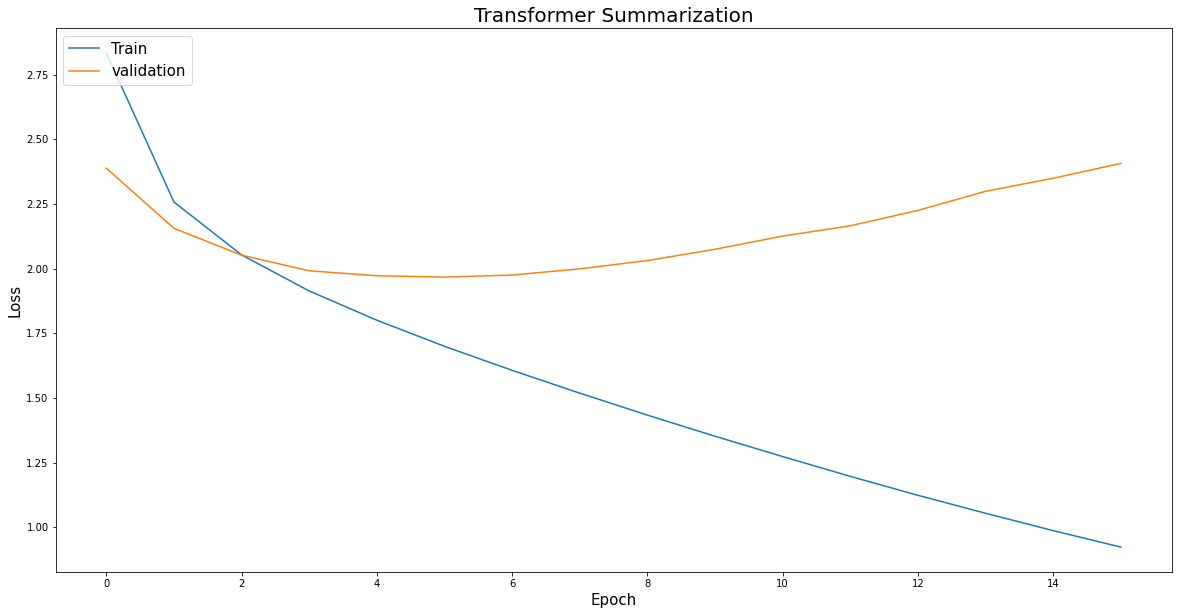

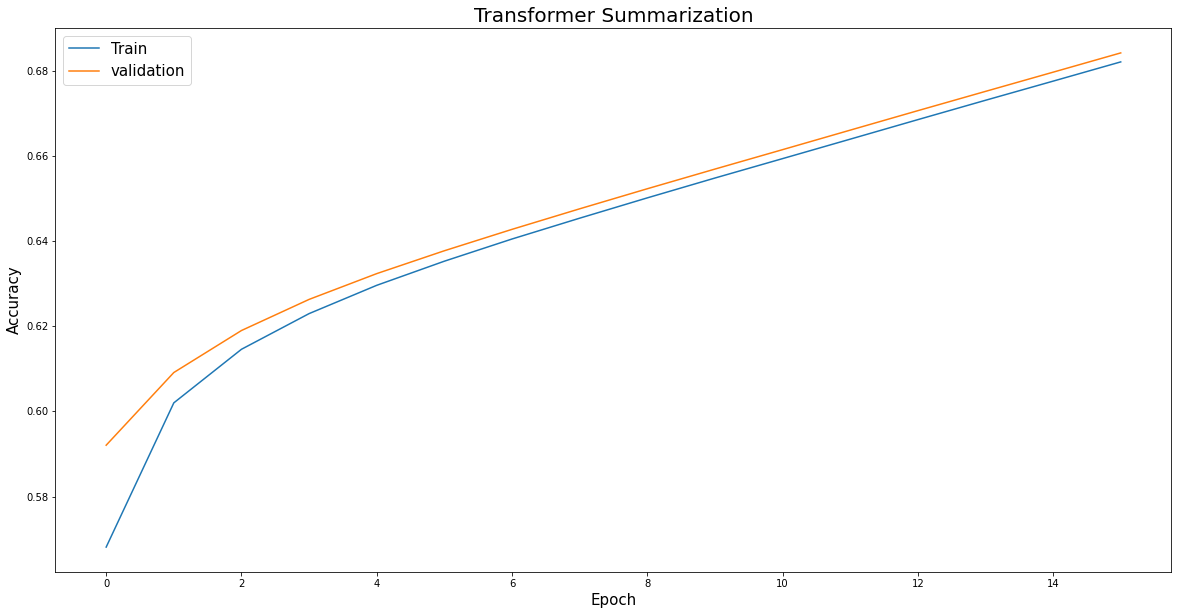

In [ ]:
# Plot training & validation loss values
plt.figure(figsize = (20, 10))
plt.plot(history_transformer.history['loss'])
plt.plot(history_transformer.history['val_loss'])
plt.title('Transformer Summarization', fontsize = 20)
plt.ylabel('Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.legend(['Train', 'validation'], loc='upper left', fontsize = 15)
plt.show();

# Plot training & validation accuracy values
plt.figure(figsize = (20, 10))
plt.plot(history_transformer.history['accuracy'])
plt.plot(history_transformer.history['val_accuracy'])
plt.title('Transformer Summarization', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.legend(['Train', 'validation'], loc='upper left', fontsize = 15)
plt.show();

#### 검증 진행

In [ ]:
transformer_acc = model.evaluate([encoder_input_test, decoder_input_test], decoder_target_test)

1985/1985 [==============================] - 180s 91ms/step - loss: 1.9673 - accuracy: 0.6835


In [ ]:
score = pd.DataFrame({'Score' :['Loss', 'Accuracy'],'Attention':[attention_score_test[0], attention_score_test[1]], 'Transformer':[1.9580, 0.6835]})
score

,Score,Attention,Transformer
0,Loss,2.061288,1.9580
1,Accuracy,0.634445,0.6835


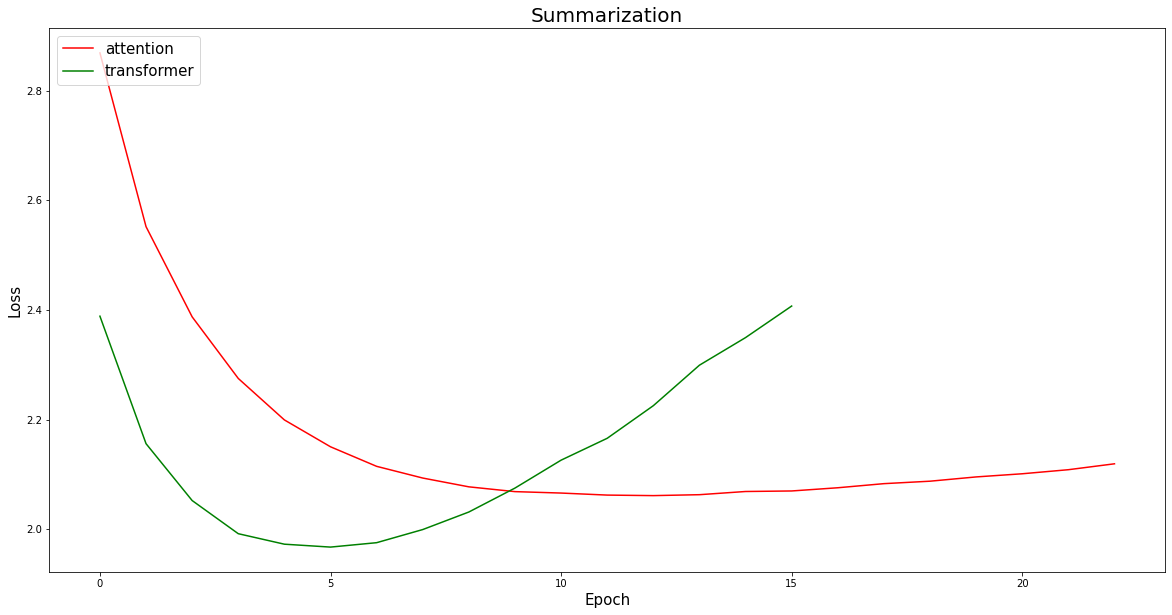

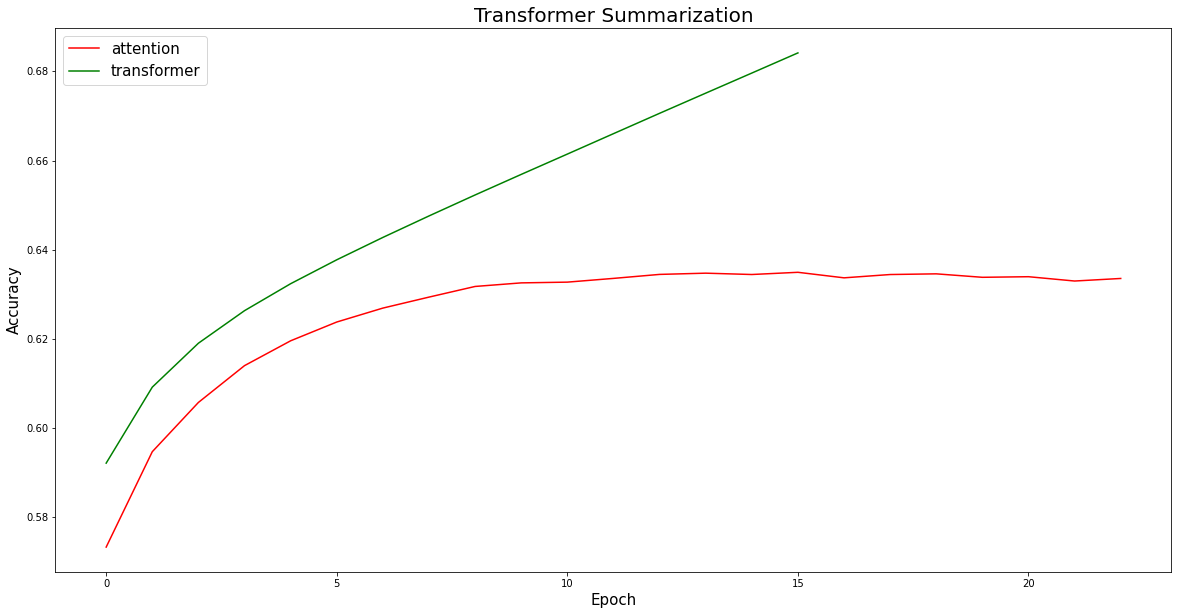

In [ ]:
# Plot training & validation loss values
plt.figure(figsize = (20, 10))
plt.plot(history.history['val_loss'], color = 'red', label = 'attention')
plt.plot(history_transformer.history['val_loss'], color = 'green', label = 'transformer')
plt.title('Summarization', fontsize = 20)
plt.ylabel('Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.legend(['attention', 'transformer'], loc='upper left', fontsize = 15)
plt.show();

# Plot training & validation accuracy values
plt.figure(figsize = (20, 10))
plt.plot(history.history['val_accuracy'], color = 'red', label = 'attention')
plt.plot(history_transformer.history['val_accuracy'], color = 'green', label = 'transformer')
plt.title('Transformer Summarization', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.legend(['attention', 'transformer'], loc='upper left', fontsize = 15)
plt.show();

In [ ]:
pip freeze > requirements.txt